In [70]:
import torch


def euler2mat(angle):
    """Convert euler angles to rotation matrix.
     :param angle: [3] or [b, 3]
     :return
        rotmat: [3, 3] or [b, 3, 3]
    source
    https://github.com/ClementPinard/SfmLearner-Pytorch/blob/master/inverse_warp.py
    """

    if len(angle.size()) == 1:
        x, y, z = angle[0], angle[1], angle[2]
        _dim = 0
        _view = [3, 3]
    elif len(angle.size()) == 2:
        b, _ = angle.size()
        x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]
        _dim = 1
        _view = [b, 3, 3]

    else:
        assert False

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    # zero = torch.zeros([b], requires_grad=False, device=angle.device)[0]
    # one = torch.ones([b], requires_grad=False, device=angle.device)[0]
    zero = z.detach()*0
    one = zero.detach()+1
    zmat = torch.stack([cosz, -sinz, zero,
                        sinz, cosz, zero,
                        zero, zero, one], dim=_dim).reshape(_view)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zero, siny,
                        zero, one, zero,
                        -siny, zero, cosy], dim=_dim).reshape(_view)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([one, zero, zero,
                        zero, cosx, -sinx,
                        zero, sinx, cosx], dim=_dim).reshape(_view)

    rot_mat = xmat @ ymat @ zmat
    # print(rot_mat)
    return rot_mat


def distribute(depth, _x, _y, size_x, size_y, image_height, image_width):
    """
    Distributes the depth associated with each point to the discrete coordinates (image_height, image_width) in a region
    of size (size_x, size_y).
    :param depth:
    :param _x: [batch, num_points]
    :param _y: [batch, num_points]
    :param size_x:
    :param size_y:
    :param image_height:
    :param image_width:
    :return:
    """

    assert size_x % 2 == 0 or size_x == 1
    assert size_y % 2 == 0 or size_y == 1
    batch, _ = depth.size()
    epsilon = torch.tensor([1e-12], requires_grad=False, device=depth.device)
    _i = torch.linspace(-size_x / 2, (size_x / 2) - 1, size_x, requires_grad=False, device=depth.device)
    _j = torch.linspace(-size_y / 2, (size_y / 2) - 1, size_y, requires_grad=False, device=depth.device)

    extended_x = _x.unsqueeze(2).repeat([1, 1, size_x]) + _i  # [batch, num_points, size_x]
    extended_y = _y.unsqueeze(2).repeat([1, 1, size_y]) + _j  # [batch, num_points, size_y]

    extended_x = extended_x.unsqueeze(3).repeat([1, 1, 1, size_y])  # [batch, num_points, size_x, size_y]
    extended_y = extended_y.unsqueeze(2).repeat([1, 1, size_x, 1])  # [batch, num_points, size_x, size_y]

    extended_x.ceil_()
    extended_y.ceil_()

    value = depth.unsqueeze(2).unsqueeze(3).repeat([1, 1, size_x, size_y])  # [batch, num_points, size_x, size_y]

    # all points that will be finally used
    masked_points = ((extended_x >= 0)
                     * (extended_x <= image_height - 1)
                     * (extended_y >= 0)
                     * (extended_y <= image_width - 1)
                     * (value >= 0))

    true_extended_x = extended_x
    true_extended_y = extended_y

    # to prevent error
    extended_x = (extended_x % image_height)
    extended_y = (extended_y % image_width)

    # [batch, num_points, size_x, size_y]
    distance = torch.abs((extended_x - _x.unsqueeze(2).unsqueeze(3))
                         * (extended_y - _y.unsqueeze(2).unsqueeze(3)))
    weight = (masked_points.float()
          * (1 / (value + epsilon)))  # [batch, num_points, size_x, size_y]
    weighted_value = value * weight
    # weighted_value = value

    weight = weight.view([batch, -1])
    weighted_value = weighted_value.view([batch, -1])

    coordinates = (extended_x.view([batch, -1]) * image_width) + extended_y.view(
        [batch, -1])
    coord_max = image_height * image_width
    true_coordinates = (true_extended_x.view([batch, -1]) * image_width) + true_extended_y.view(
        [batch, -1])
    true_coordinates[~masked_points.view([batch, -1])] = coord_max

    weight_scattered = torch.zeros(
        [batch, image_width * image_height],
        device=depth.device).scatter_add(1, coordinates.long(), weight)

    masked_zero_weight_scattered = (weight_scattered == 0.0)
    weight_scattered += masked_zero_weight_scattered.float()

    weighed_value_scattered = torch.zeros(
        [batch, image_width * image_height],
        device=depth.device).scatter_add(1, coordinates.long(), weighted_value)

    return weighed_value_scattered,  weight_scattered


def points2depth(points, image_height, image_width, color, size_x=4, size_y=4):
    """
    :param points: [B, num_points, 3]
    :param image_width:
    :param image_height:
    :param size_x:
    :param size_y:
    :return:
        depth_recovered: [B, image_width, image_height]
    """

    # print(points[0, :, 0].max(), points[:, :, 0].min())
    epsilon = torch.tensor([1e-12], requires_grad=False, device=points.device)
    # epsilon not needed, kept here to ensure exact replication of old version
    # coord_x = (points[:, :, 0] / (points[:, :, 2] + epsilon)) * (image_width / image_height)  # [batch, num_points]
    # coord_y = (points[:, :, 1] / (points[:, :, 2] + epsilon))  # [batch, num_points]
    coord_x = points[:, :, 0] /3 * (image_width / image_height) # [batch, num_points]
    coord_y = points[:, :, 1] /3 # [batch, num_points]

    batch, total_points, _ = points.size()
    if color is not None:
        depth = color
    else:
        depth = points[:, :, 2]  # [batch, num_points]
    # pdb.set_trace()
    _x = ((coord_x + 1) * image_height) / 2
    _y = ((coord_y + 1) * image_width) / 2
    
    weighed_value_scattered, weight_scattered = distribute(
        depth=depth,
        _x=_x,
        _y=_y,
        size_x=size_x,
        size_y=size_y,
        image_height=image_height,
        image_width=image_width)

    depth_recovered = (weighed_value_scattered / weight_scattered).view([
        batch, image_height, image_width
    ])

    return depth_recovered

def point_transform(points, rot_mat, translation):
        """
        :param points: [batch, num_points, 3]
        :param rot_mat: [batch, 3]
        :param translation: [batch, 1, 3]
        :return:
        """
        rot_mat = rot_mat.to(points.device)
        translation = translation.to(points.device)
        points = torch.matmul(points, rot_mat)
        points = points - translation
        return points


In [1]:
import torch.nn as nn
import numpy as np
import torch
import open3d as o3d
import matplotlib.pyplot as plt
import cv2
import torch_scatter as scatter


def euler2mat(angle):
    """Convert euler angles to rotation matrix.
     :param angle: [3] or [b, 3]
     :return
        rotmat: [3, 3] or [b, 3, 3]
    source
    https://github.com/ClementPinard/SfmLearner-Pytorch/blob/master/inverse_warp.py
    """

    if len(angle.size()) == 1:
        x, y, z = angle[0], angle[1], angle[2]
        _dim = 0
        _view = [3, 3]
    elif len(angle.size()) == 2:
        b, _ = angle.size()
        x, y, z = angle[:, 0], angle[:, 1], angle[:, 2]
        _dim = 1
        _view = [b, 3, 3]

    else:
        assert False

    cosz = torch.cos(z)
    sinz = torch.sin(z)

    # zero = torch.zeros([b], requires_grad=False, device=angle.device)[0]
    # one = torch.ones([b], requires_grad=False, device=angle.device)[0]
    zero = z.detach()*0
    one = zero.detach()+1
    zmat = torch.stack([cosz, -sinz, zero,
                        sinz, cosz, zero,
                        zero, zero, one], dim=_dim).reshape(_view)

    cosy = torch.cos(y)
    siny = torch.sin(y)

    ymat = torch.stack([cosy, zero, siny,
                        zero, one, zero,
                        -siny, zero, cosy], dim=_dim).reshape(_view)

    cosx = torch.cos(x)
    sinx = torch.sin(x)

    xmat = torch.stack([one, zero, zero,
                        zero, cosx, -sinx,
                        zero, sinx, cosx], dim=_dim).reshape(_view)

    rot_mat = xmat @ ymat @ zmat
    # print(rot_mat)
    return rot_mat

def point_transform(points, rot_mat, translation):
        """
        :param points: [batch, num_points, 3]
        :param rot_mat: [batch, 3]
        :param translation: [batch, 1, 3]
        :return:
        """
        rot_mat = rot_mat.to(points.device)
        translation = translation.to(points.device)
        points = torch.matmul(points, rot_mat)
        points = points - translation
        return points

def get_bbox(path):
    instance_bboxes = np.load(path)
    target_bboxes = np.zeros((64, 6))
    target_bboxes[0: instance_bboxes.shape[0], :] = instance_bboxes[:, 0:6]
    gt_centers = target_bboxes[:, 0:3]
    gt_centers[instance_bboxes.shape[0]:, :] += 1000.0
    size_gts = np.zeros((64, 3))
    size_gts[0:instance_bboxes.shape[0], :] = target_bboxes[0:instance_bboxes.shape[0], 3:6]
    
    return gt_centers, size_gts

def get_bbox_2d(gt_centers, size_gts, x_min, y_min, scale):
    centers = gt_centers[:, :, :2] # [B, 64, 2]
    sizes = size_gts['size_gts'][:, :, :2]
    centers[:, :, 0] = (centers[:, :, 0] - x_min) * scale
    centers[:, :, 1] = (centers[:, :, 1] - y_min) * scale
    sizes = sizes * scale.unsqueeze(-1) # [B, 64, 2]
    box2d = torch.cat([centers, sizes], dim=2)
    
    return box2d

def points2img(points, colors, angle, translation, image_height, image_width, size_x=4, size_y=4, return_info=False, step=False):
    """ Points to Image

    Args:
        points (Torch.Tensor): [B, num_points, 3]
        colors (Torch.Tensor): [B, num_points, 3] or None
        angle (Torch.Tensor): [v, 3]
        translation (Torch.Tensor): [v, 3]
        image_height (int): 
        image_width (int): 
        size_x (int, optional): _description_. Defaults to 4.
        size_y (int, optional): _description_. Defaults to 4.
        
    Return:
        imgs (Torch.Tensor): [B, v, image_height, image_width, 3]
    """
    B_ori, N, _ = points.shape
    
    v = angle.shape[0]
    angle = angle.to(points.device)
    rot_mat = euler2mat(angle).transpose(1, 2)
    
    # translation = torch.tensor(views_[:, 1, :]).float().to(points_.device)
    # translation = translation.unsqueeze(1)
    if torch.is_tensor(translation):
        trans = translation
    elif translation == 'mid':
        points_mean = points.mean(dim=1).unsqueeze(1) # [batch, 1, 3]
        trans = points_mean
    elif translation == 'min':
        points_min = points.min(dim=1)[0].unsqueeze(1)
        trans = points_min
    else:
        trans = torch.tensor([[0, 0, 0]]).to(points.device)
    
    points -= trans
    points = torch.matmul(points.unsqueeze(1), rot_mat) # [batch, v, num_points, 3]
    points = points.reshape(-1, N, 3)
    # print((points[:, :, 2] <= 0).shape)
    t = points[:, :, 2].min(dim=1, keepdim=True)[0]/2
    # if step:
    #     points = points * (points[:, :, 2] <= t).unsqueeze(-1)
    # else:
    #     points = points * (points[:, :, 2] <= 0).unsqueeze(-1)
    sel = torch.zeros_like(points)
    sel[0:4, :, :] = (points[0:4, :, 2] <= 0).unsqueeze(-1)
    sel[4:12, :, :] = (points[4:12, :, 2] <= t[4:12]).unsqueeze(-1)
    
    points[0:4, :, :] = points[0:4, :, :] * (points[0:4, :, 2] <= 0).unsqueeze(-1)
    points[4:12, :, :] = points[4:12, :, :] * (points[4:12, :, 2] <= t[4:12]).unsqueeze(-1)
    # points = points * (points[:, :, 2] <= 0).unsqueeze(-1)
    # print(points.shape)
    B = B_ori*v
    if colors is not None:
        colors = torch.repeat_interleave(colors, v, dim=0)
    
    assert size_x % 2 == 0 or size_x == 1
    assert size_y % 2 == 0 or size_y == 1
    
    
    coord_x = points[:, :, 0] - points[:, :, 0].min(dim=1)[0].unsqueeze(-1) # [batch, num_points]
    coord_y = points[:, :, 1] - points[:, :, 1].min(dim=1)[0].unsqueeze(-1) # [batch, num_points]

    scale = torch.min(torch.stack([(image_width-size_x)/coord_x.max(dim=1)[0].unsqueeze(-1), 
                          (image_height-size_y)/coord_y.max(dim=1)[0].unsqueeze(-1)], dim=0), dim=0)[0]
    
    coord_x = coord_x * scale + size_x/2
    coord_y = coord_y * scale + size_y/2
    
    _i = torch.linspace(-size_x/2, size_x/2-1, size_x, requires_grad=False, device=points.device)
    _j = torch.linspace(-size_y/2, size_y/2-1, size_y, requires_grad=False, device=points.device)
    
    extended_x = coord_x.unsqueeze(2).repeat([1, 1, size_x]) + _i # [batch, num_points, size_x]
    extended_y = coord_y.unsqueeze(2).repeat([1, 1, size_y]) + _j # [batch, num_points, size_y]
    extended_x = torch.clamp(extended_x, 0, image_width-1)
    extended_y = torch.clamp(extended_y, 0, image_height-1)
    
    extended_x = extended_x.ceil().long()
    extended_y = extended_y.ceil().long()
    
    extended_x = extended_x.unsqueeze(3).repeat([1, 1, 1, size_y]) # [batch, num_points, size_x, size_y]
    extended_y = extended_y.unsqueeze(2).repeat([1, 1, size_x, 1]) # [batch, num_points, size_x, size_y]
    
    # print(extended_x.min(), extended_x.max(), extended_y.min(), extended_y.max())
    # print(extended_x.shape, extended_y.shape)
    
    depth = points[:, :, 2]
    depth -= depth.min(dim=1)[0].unsqueeze(-1)
    depth /= depth.max(dim=1)[0].unsqueeze(-1)
    depth = depth.unsqueeze(1).unsqueeze(3).unsqueeze(4).repeat(1, 3, 1, size_x, size_y)
    if colors is not None:
        if colors.max() > 1:
            colors = colors / 255
        value = colors.unsqueeze(3).unsqueeze(4).repeat(1, 1, 1, size_x, size_y).permute(0, 2, 1, 3, 4) # [batch, 3, num_points, size_x, size_y]
    else:
        value = depth  # [batch, 3, num_points, size_x, size_y]
    
    coordinates = extended_x.reshape([B, -1]) * image_width + extended_y.reshape([B, -1]) # [batch, num_points*size_x*size_y]   
    coordinates = coordinates.unsqueeze(1).repeat(1, 3, 1) # [batch, 3, num_points*size_x*size_y]    
    coordinates[:, 1, :] += image_height * image_width
    coordinates[:, 2, :] += image_height * image_width * 2
    coordinates = coordinates.reshape([B, -1]) # [batch, 3*num_points*size_x*size_y]
    
    value = value.reshape([B, -1])
    
    # imgs = torch.zeros([B, 3*image_height*image_width], device='cpu')
    # coordinates = coordinates.to('cpu')
    # value = value.to('cpu')
    # imgs = imgs.scatter_(1, coordinates.long(), value)
    # imgs = imgs.to(points.device)
    
    depth = depth.reshape([B, -1]) * 1000
    depth = depth.floor()
    if colors is not None:
        depth += (value / 2)
    imgs = torch.zeros([B, 3*image_height*image_width]).to(points.device)
    out, argmax = scatter.scatter_max(src=depth, index=coordinates.long(), out=imgs, dim=1)
    if colors is not None:
        imgs -= imgs.floor()
        imgs *= 2

    imgs = imgs.reshape([B_ori, v, 3, image_height, image_width])
    
    if not return_info:
        return imgs
    else:
        info = {}
        info['x_min'] = points[:, :, 0].min(dim=1)[0].unsqueeze(-1) # [batch, 1]
        info['y_min'] = points[:, :, 1].min(dim=1)[0].unsqueeze(-1) # [batch, 1]
        info['scale'] = scale
        info['rot_mat'] = rot_mat
        info['through'] = t
        return imgs, info


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


['scene0000_00_aligned_vert.npy', 'scene0000_02_aligned_vert.npy', 'scene0002_00_aligned_vert.npy', 'scene0003_00_vert.npy', 'scene0007_00_aligned_vert.npy', 'scene0008_00_aligned_vert.npy', 'scene0009_00_vert.npy', 'scene0013_00_vert.npy', 'scene0016_02_vert.npy', 'scene0017_00_aligned_vert.npy', 'scene0019_00_vert.npy', 'scene0020_00_vert.npy', 'scene0025_01_vert.npy', 'scene0035_01_vert.npy', 'scene0250_02_vert.npy', 'scene0306_01_vert.npy']


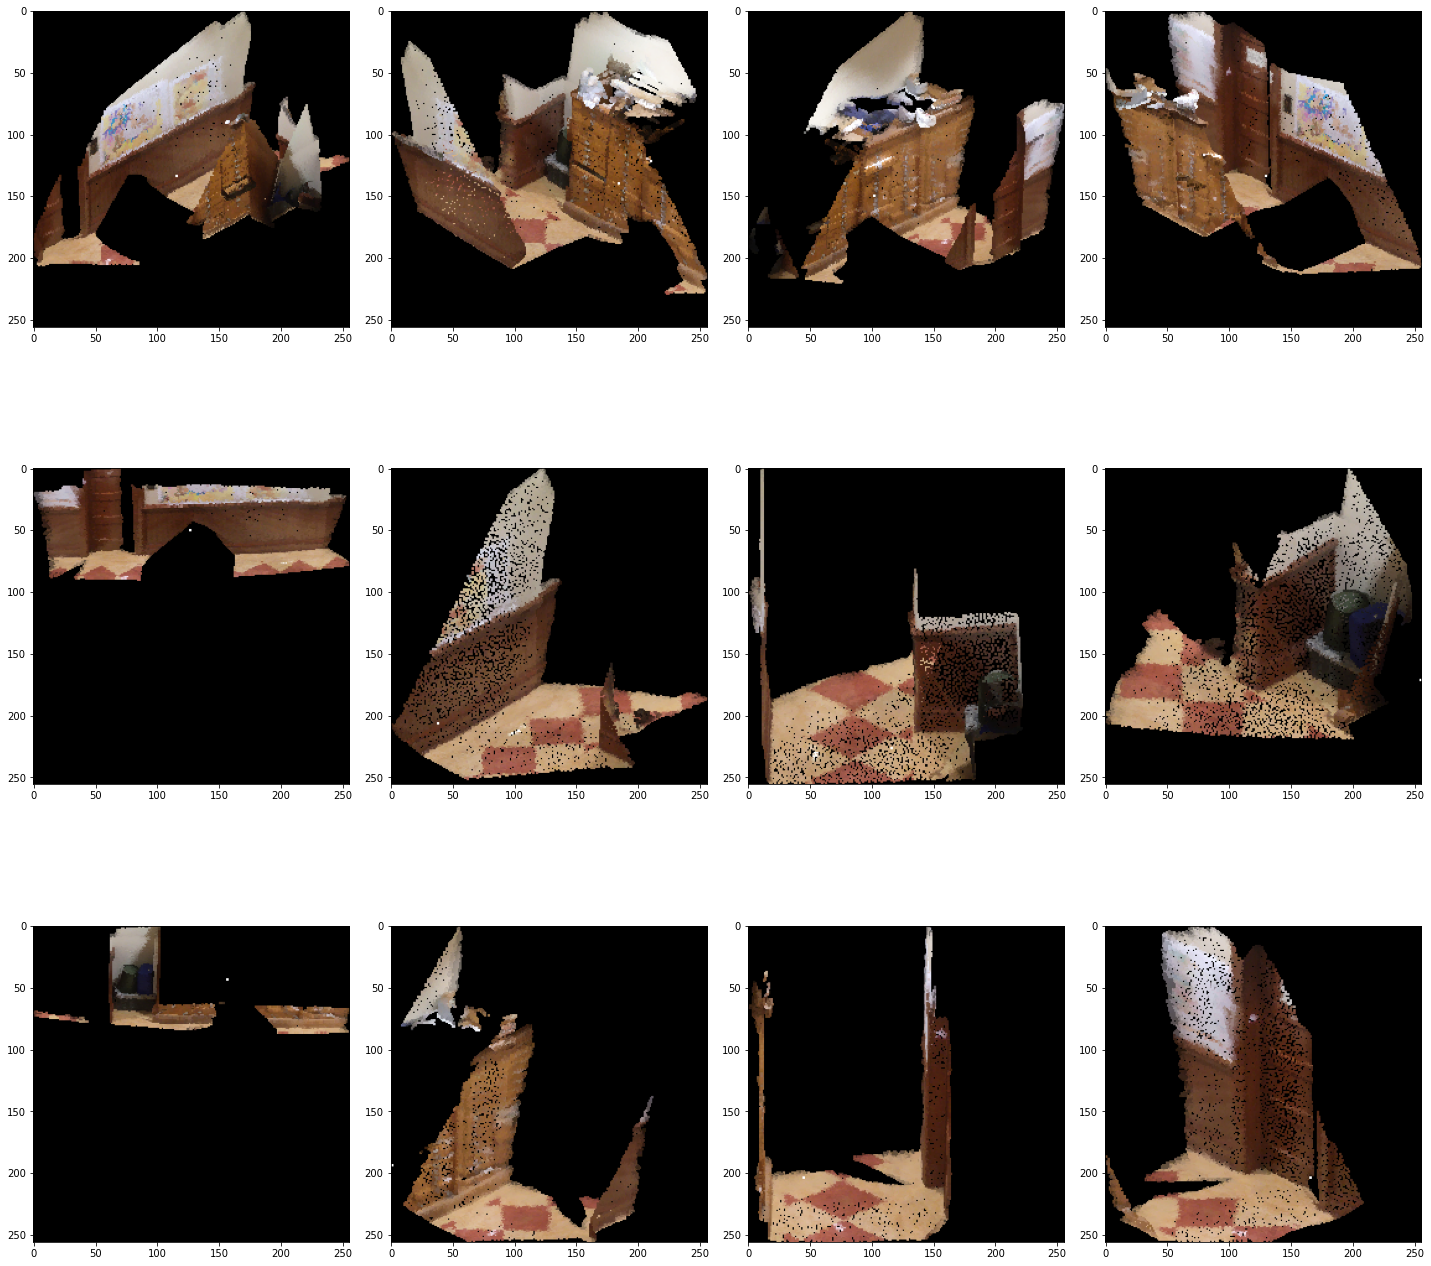

In [2]:
import os
angles = torch.tensor([
                [0, -np.pi/3, np.pi/4],
                [0, -np.pi/3, 3*np.pi/4],
                [0, -np.pi/3, 5*np.pi/4],
                [0, -np.pi/3, 7*np.pi/4],
                
                [0, -np.pi/3, 0],
                [0, -np.pi/3, np.pi/4],
                [0, -np.pi/3, 2*np.pi/4],
                [0, -np.pi/3, 3*np.pi/4],
                [0, -np.pi/3, 4*np.pi/4],
                [0, -np.pi/3, 5*np.pi/4],
                [0, -np.pi/3, 6*np.pi/4],
                [0, -np.pi/3, 7*np.pi/4]
                ])

plt.figure(figsize=(20, 20))


name = os.listdir('./scenes/')
name = [n for n in name if n.endswith('.npy')]
pts = []
cls = []
print(name)
idx = 2
n = "scene0007_00_aligned_vert.npy"
# pcd = o3d.io.read_point_cloud(os.path.join('./raw_scenes/', n))
# points = torch.tensor(np.asarray(pcd.points)).float()
# colors = torch.tensor(np.asarray(pcd.colors)).float()

mesh_vertices = np.load(os.path.join('./scenes/', n))
points = torch.tensor(mesh_vertices[:, 0:3])
colors = torch.tensor(mesh_vertices[:, 3:6])

points = points.unsqueeze(0)
colors = colors.unsqueeze(0)

imgs = points2img(points, angle=angles, translation='mid', image_height=256, image_width=256, colors=colors, size_x=2, size_y=2, return_info=False)
    
for v in range(angles.shape[0]):
    img = imgs[0, v].detach().numpy().transpose(1, 2, 0)
    plt.subplot(3, 4, v+1)
    plt.imshow(img)

plt.tight_layout()    
plt.show()

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(mesh_vertices[:, 0:3])
# pcd.colors = o3d.utility.Vector3dVector(mesh_vertices[:, 3:6]/255)
# o3d.visualization.draw_geometries([pcd])


In [ ]:
# pcd = o3d.io.read_point_cloud("pc.ply")
# points = torch.tensor(np.asarray(pcd.points))
# points = points.unsqueeze(0).float().repeat(2, 1, 1)
# depth = points[0, :, 2]
# colors = torch.tensor(np.asarray(pcd.colors)).float().unsqueeze(0)
# colors = torch.stack([colors, depth.unsqueeze(-1).repeat(1, 1, 3)], dim=1).squeeze(0)
# print(colors.shape, points.shape)
# imgs = points2img(points, image_height=256, image_width=256, colors=colors, size_x=2, size_y=2)

import os
# name = os.listdir('./scenes/')
# name = [n for n in name if n.endswith('.npy')]
# pts = []
# cls = []
# centers = []
# sizes = []
# for n in name:
#     mesh_vertices = np.load(os.path.join('./scenes/', n))
#     points = torch.tensor(mesh_vertices[:, 0:3])
#     colors = torch.tensor(mesh_vertices[:, 3:6])
#     # center, size = get_bbox(n.replace('vert', 'bbox')) 
    
#     pts.append(points)
#     cls.append(colors)
#     # centers.append(center)
#     # sizes.append(size)
# points = torch.stack(pts, dim=0)
# colors =  torch.stack(cls, dim=0)

# name = os.listdir('./raw_scenes/')
# name = [n for n in name if n.endswith('.ply')]
# pts = []
# cls = []
# for n in name:
#     pcd = o3d.io.read_point_cloud(os.path.join('./raw_scenes/', n))
#     points = torch.tensor(np.asarray(pcd.points)).float()
#     colors = torch.tensor(np.asarray(pcd.colors)).float()
    
#     pts.append(points)
#     cls.append(colors)
    
# points = torch.stack(pts, dim=0)
# colors =  torch.stack(cls, dim=0)

# # centers = torch.stack(centers, dim=0)
# # sizes = torch.stack(sizes, dim=0)

# # angles = torch.tensor([[np.pi/4, np.pi/4, -np.pi/4],
# #                        [np.pi/4, -np.pi/4, np.pi/4],
# #                        [-np.pi/4, -np.pi/4, np.pi/4],
# #                        [np.pi/4, -np.pi/4, -np.pi/4]])

# # angles = torch.tensor([[0, -np.pi/2, 0],
# #                        [np.pi/2, -np.pi/2, 0],
# #                        [np.pi/2, -np.pi/2, np.pi],
# #                        [0, -np.pi/2, np.pi]])

# angles = torch.tensor([[0, -np.pi/3, 0],
#                        [0, -np.pi/3, np.pi/4],
#                        [0, -np.pi/3, 2*np.pi/4],
#                        [0, -np.pi/3, 3*np.pi/4],
#                        [0, -np.pi/3, 4*np.pi/4],
#                        [0, -np.pi/3, 5*np.pi/4],
#                        [0, -np.pi/3, 6*np.pi/4],
#                        [0, -np.pi/3, 7*np.pi/4]])

# imgs, info = points2img(points, angle=angles, translation='mean', image_height=256, image_width=256, colors=colors, size_x=4, size_y=4, return_info=True)

# plt.rcParams['figure.figsize'] = (20, 20)

# # plt.subplot(1, 2, 1)
# # img = imgs[0].squeeze(0).detach().numpy().transpose(1, 2, 0)
# # plt.imshow(img)
# # plt.subplot(1, 2, 2)
# # img = imgs[1].squeeze(0).detach().numpy().transpose(1, 2, 0)
# for i in range(angles.shape[0]):
#     idx = 7, i
#     img = imgs[idx].detach().numpy().transpose(1, 2, 0)
#     plt.subplot(2, 4, i+1)
#     plt.imshow(img)
# # plt.savefig("scene0306_01.png")
# plt.tight_layout()
# plt.show()

# p = points[idx[0]].detach().numpy()
# c = colors[idx[0]].detach().numpy()/255
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(p)
# pcd.colors = o3d.utility.Vector3dVector(c)
# o3d.visualization.draw_geometries([pcd])

In [ ]:
print("-- data_dict info --")
for key in end_points.keys():
    if torch.is_tensor(end_points[key]):
        print(f"{key}: {end_points[key].size()}")
    elif isinstance(end_points[key], list):
        print(f"{key}: {len(end_points[key])}")
    else:
        print(f"{key}: {end_points[key]}")

torch.Size([1, 40000, 3])
torch.Size([6, 40000])
tensor(2.5707) tensor(-3.0636)
torch.Size([6, 40000])
tensor(2.5707) tensor(-3.0636)
torch.Size([6, 40000])
tensor(2.5707) tensor(-3.0636)


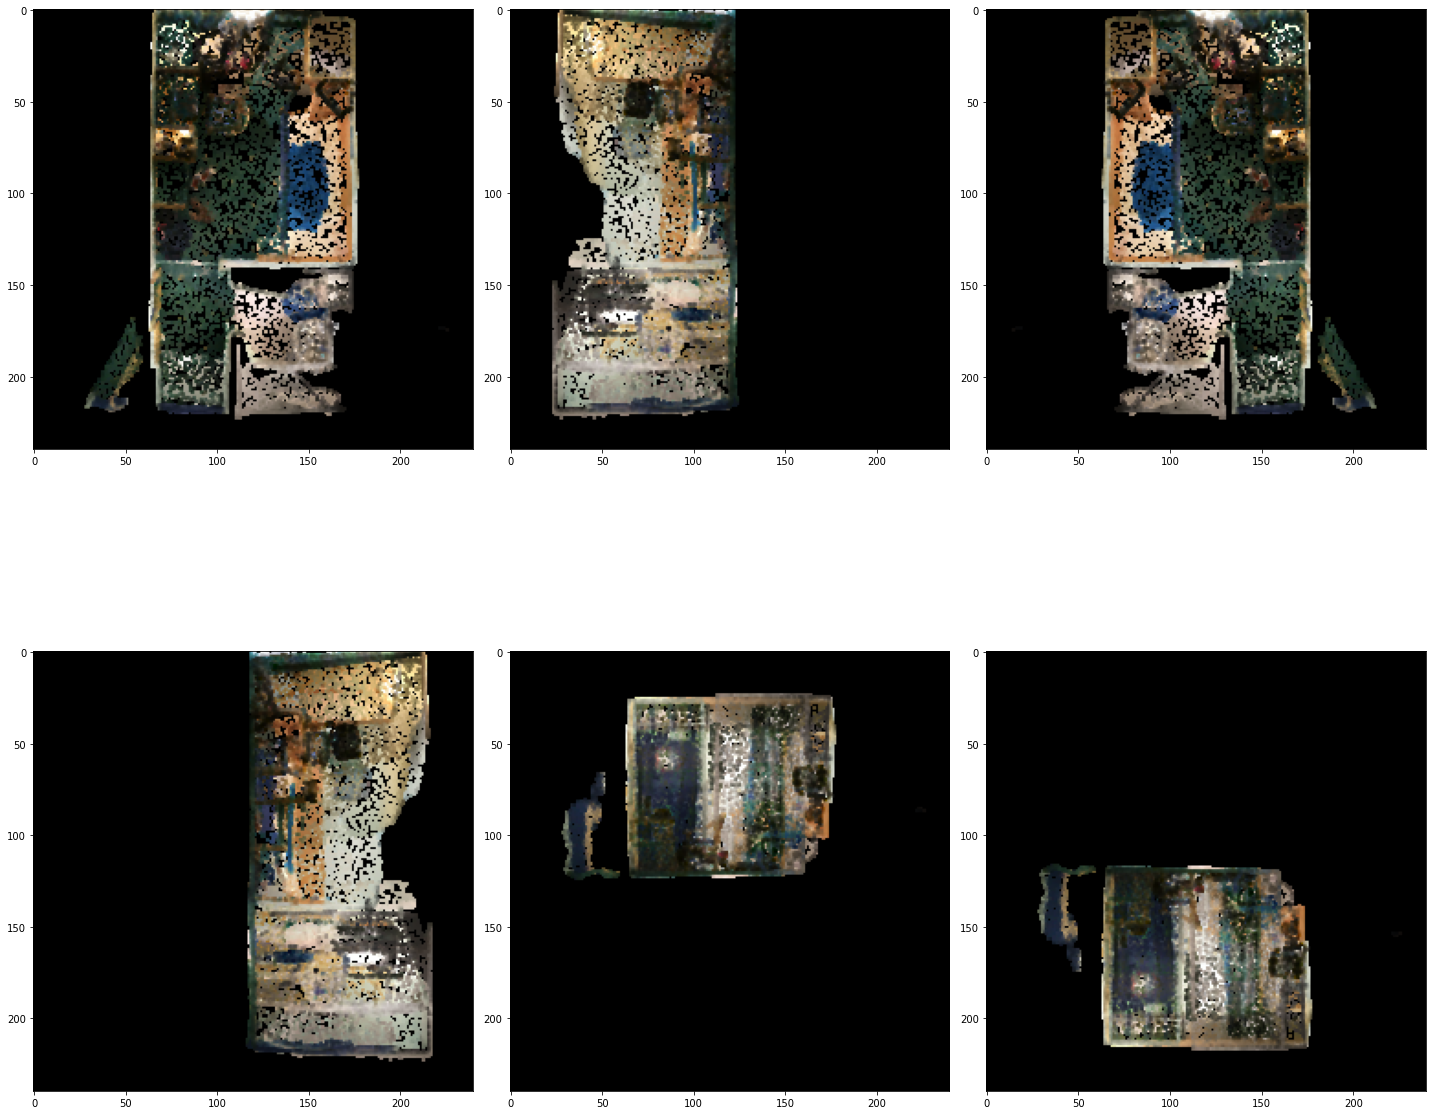

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: 不支持请求的转换操作。 


In [63]:
import open3d as o3d
import torch
import matplotlib.pyplot as plt

TRANS = -1.6

_views = np.asarray([
    [[0 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
    [[1 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
    [[2 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
    [[3 * np.pi / 2, 0, np.pi / 2], [0, 0, TRANS]],
    [[0, -np.pi / 2, np.pi / 2], [0, 0, TRANS]],
    [[0, np.pi / 2, np.pi / 2], [0, 0, TRANS]]]
    )
    
num_views = 6

angle = torch.tensor(_views[:, 0, :]).float()
rot_mat = euler2mat(angle).transpose(1, 2)
translation = torch.tensor(_views[:, 1, :]).float()
translation = translation.unsqueeze(1)


pcd = o3d.io.read_point_cloud("pc.ply")
points = torch.tensor(np.asarray(pcd.points))
points = points.unsqueeze(0).float()
colors = torch.tensor(np.asarray(pcd.colors)).float()
print(points.shape)

b = points.shape[0]
v = translation.shape[0]
_points = point_transform(
        points=torch.repeat_interleave(points, v, dim=0),
        rot_mat=rot_mat.repeat(b, 1, 1),
        translation=translation.repeat(b, 1, 1))
# print(_points.shape)

depth_recovered = []
for i in range(3):
    color = colors[:, i].repeat(num_views, 1)
    print(color.shape)
    depth_recovered.append(points2depth(_points, image_height=240, image_width=240, color=color, size_x=2, size_y=2))
# depth_recovered = points2depth(_points, image_height=240, image_width=240, size_x=1, size_y=1)
# print(depth_recovered.shape)

plt.rcParams['figure.figsize'] = (20, 20)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = [d[i].detach().numpy() for d in depth_recovered]
    img = np.stack(img, axis=0).transpose(1, 2, 0)
    plt.imshow(img)
# plt.imshow(depth_recovered[0].detach().numpy())
plt.tight_layout()
plt.show()
# o3d.visualization.draw_geometries([pcd])

In [31]:
import json
count_dict = {}
data = json.load(open("ScanRefer_filtered_train.json"))

for d in data:
    if d["object_name"] not in count_dict:
        count_dict[d["object_name"]] = 0
    count_dict[d["object_name"]] += 1

print(len(count_dict))
sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item:item[1], reverse=True))
print(sorted_count_dict)

print(len({k: v for k, v in sorted_count_dict.items() if v > 100}))


242
{'chair': 6118, 'table': 1993, 'door': 1887, 'trash_can': 1709, 'pillow': 1286, 'cabinet': 1235, 'office_chair': 984, 'shelf': 976, 'desk': 958, 'monitor': 902, 'couch': 888, 'window': 822, 'sink': 780, 'picture': 609, 'bed': 599, 'towel': 570, 'lamp': 536, 'bookshelf': 510, 'armchair': 506, 'radiator': 496, 'curtain': 470, 'coffee_table': 467, 'kitchen_cabinets': 439, 'whiteboard': 407, 'kitchen_cabinet': 407, 'toilet': 405, 'nightstand': 369, 'stool': 363, 'recycling_bin': 334, 'dresser': 322, 'keyboard': 309, 'file_cabinet': 297, 'tv': 295, 'refrigerator': 276, 'microwave': 248, 'shower_curtain': 234, 'computer_tower': 229, 'sofa_chair': 226, 'bathtub': 221, 'toilet_paper': 219, 'end_table': 210, 'bathroom_vanity': 207, 'paper_towel_dispenser': 193, 'kitchen_counter': 189, 'ottoman': 188, 'printer': 176, 'counter': 174, 'copier': 131, 'cabinets': 128, 'suitcase': 126, 'laptop': 120, 'stove': 120, 'bench': 111, 'soap_dispenser': 107, 'mini_fridge': 102, 'backpack': 97, 'tv_stand'

In [2]:
import json
count_dict = {}
data = json.load(open("ScanRefer_filtered_train.json"))

for d in data:
    if d["object_name"] not in count_dict:
        count_dict[d["object_name"]] = 0
    count_dict[d["object_name"]] += 1
    
len(count_dict.keys())

242

In [4]:
d = eval("{'cabinet':0, 'bed':1, 'chair':2, 'sofa':3, 'table':4, 'door':5, \
         'window':6,'bookshelf':7,'picture':8, 'counter':9, 'desk':10, 'curtain':11, \
         'refrigerator':12, 'shower curtain':13, 'toilet':14, 'sink':15, 'bathtub':16, 'others':17}")

d.keys()

dict_keys(['cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain', 'refrigerator', 'shower curtain', 'toilet', 'sink', 'bathtub', 'others'])